In [1]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
import os
from glob import glob

In [3]:
def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled

In [62]:

class Data(Dataset):
    def __init__(self, wavs_path):
       
        self.data = []
        self.labels = []
        self.wavs_path = wavs_path
        self.n_fft= int(1024)
        self.hop_length= int(self.n_fft/4) #
        self.top_db = 80
        self.fmin = 20
        self.fmax = 8300
        self.sr = int(22050 * 1.0)
        
        for path in tqdm(self.wavs_path):
            self.labels.append(int(path.split('/')[-2]))
   
            wav, sr = librosa.load(path)
            start_idx = 0
            for i in range(wav.shape[0]):
                if abs(wav[i]) < 0.025: continue
                start_idx = i
                break
            wav_cut = wav[start_idx:start_idx + int(self.sr)]
            shape = wav_cut.shape[0]
            if  shape< self.sr:
                wav_cut = np.pad(wav_cut,int(np.ceil((1* self.sr-shape)/2)),mode='constant')
                wav_cut = wav_cut[: self.sr]
            
            if wav_cut.shape[0] !=  self.sr:
                print(path, wav_cut.shape)
                
            spec=librosa.feature.melspectrogram(wav_cut, sr=self.sr, n_fft=self.n_fft,hop_length=self.hop_length, fmin=self.fmin, fmax=self.fmax)
            spec_db=librosa.power_to_db(spec,top_db=self.top_db)
            self.data.append(self.spec_to_image(spec_db))
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx], idx
    
    def spec_to_image(self,spec, eps=1e-6):
        mean = spec.mean()
        std = spec.std()
        spec_norm = (spec - mean) / (std + eps)
        spec_min, spec_max = spec_norm.min(), spec_norm.max()
        spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
        spec_scaled = spec_scaled.astype(np.uint8)
        return spec_scaled


      
          
        

In [63]:
class Model(nn.Module):
    def __init__(self, input_shape, batch_size=16, num_category=20):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size = 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn8 = nn.BatchNorm2d(256)
        self.dense1 = nn.Linear(256*(((input_shape[1]//2)//2)//2)*(((input_shape[2]//2)//2)//2),500)
        self.dropout = nn.Dropout(0.5)
        self.dense2 = nn.Linear(500, num_category)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = F.max_pool2d(x, kernel_size=2) 
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv5(x)
        x = F.relu(self.bn5(x))
        x = self.conv6(x)
        x = F.relu(self.bn6(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv7(x)
        x = F.relu(self.bn7(x))
        x = self.conv8(x)
        x = F.relu(self.bn8(x))
        x = x.view(x.size(0),-1)
        x = F.relu(self.dense1(x))
        x = self.dropout(x)
        x = self.dense2(x)
        return x

In [64]:
if torch.cuda.is_available():
    device=torch.device('cuda:0')
else:
    device=torch.device('cpu')
    
def setlr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

In [65]:
wavs_path = glob(os.path.join('/home/lab/Documents/Human/Elevator_Sound_Classification/Test', '*', '*'))
test_data = Data(wavs_path)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

shape = test_data.__getitem__(0)[0].shape
model = Model(input_shape=(1,shape[0],shape[1]), batch_size=16, num_category=20).to(device)

loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/home/lab/pytoch1.5/lib/python3.6/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


ground truth: 16 prediction: 15
tensor([51, 14, 57, 42, 40,  0, 59, 44, 10, 35, 16, 25, 46, 41,  8, 21])
46
ground truth: 7 prediction: 10
tensor([51, 14, 57, 42, 40,  0, 59, 44, 10, 35, 16, 25, 46, 41,  8, 21])
21
ground truth: 2 prediction: 15
tensor([19, 48,  9, 47, 32, 39, 58,  3, 37, 24, 36,  5, 11, 55, 45, 56])
58
ground truth: 16 prediction: 15
tensor([19, 48,  9, 47, 32, 39, 58,  3, 37, 24, 36,  5, 11, 55, 45, 56])
45
ground truth: 8 prediction: 10
tensor([23, 26, 52,  4,  7, 43, 15, 31, 38, 28, 22, 30, 49, 20, 17, 18])
31
ground truth: 14 prediction: 13
tensor([12,  6,  2, 54, 13, 33, 53, 50,  1, 34, 27, 29])
33
ground truth: 17 prediction: 13
tensor([12,  6,  2, 54, 13, 33, 53, 50,  1, 34, 27, 29])
53
error count 7


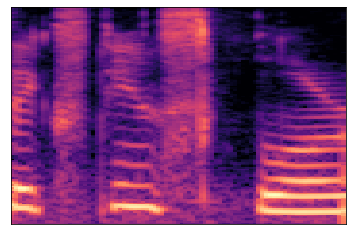

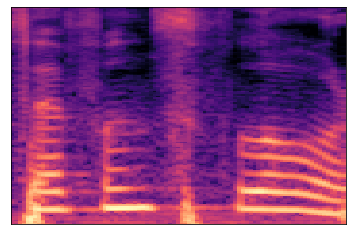

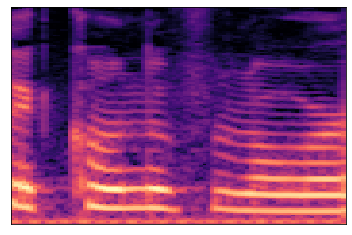

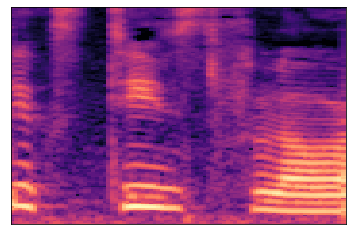

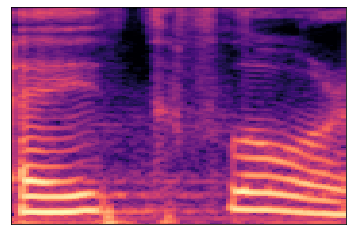

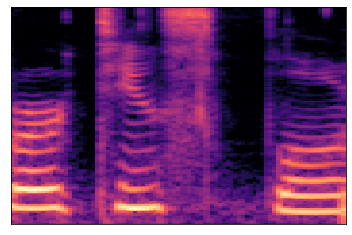

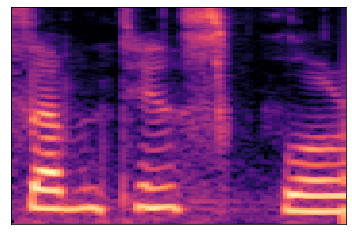

In [67]:


checkpoint = torch.load(os.path.join(os.path.abspath('.'), 'django_web/parameters','parameters.pth'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


model.eval()
count = 0
for i, data in enumerate(test_loader):
    x, y, idx = data
    x_origin = x.clone().cpu().numpy()
    batch, height, width = x.size()
    x = x.view(batch, 1, height, width)
    x = x.to(device, dtype=torch.float32)
    y = y.to(device, dtype=torch.long)
    y_hat = model(x)
    
    

    for b in range(batch):
        pred = (torch.argmax(y_hat[b]) +1).item()
        ground_truth = y[b].item()  
        if ground_truth!= pred:
            print("ground truth:",ground_truth, 'prediction:',pred )
            plt.figure()
            print(idx)
            i = idx[b].item()
            print(i)
            librosa.display.specshow(test_data.__getitem__(i)[0])
            
            count +=1
            
print("error count", count)


/home/lab/pytoch1.5/lib/python3.6/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



1
10
11
12
13
14
15
16
17
18
19
2
20
3
4
5
6
7
8
9


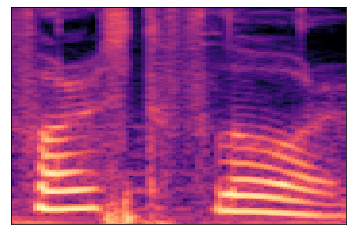

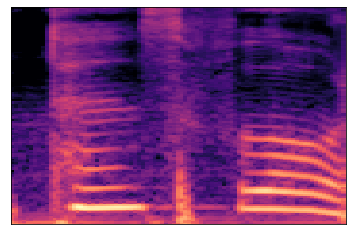

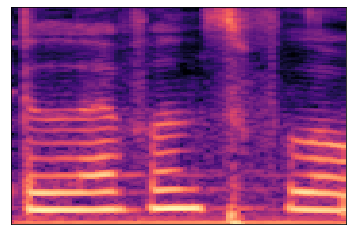

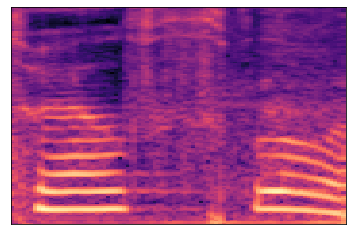

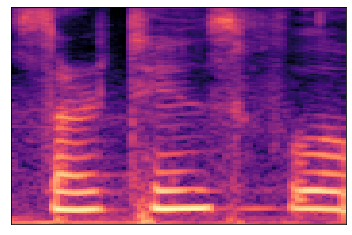

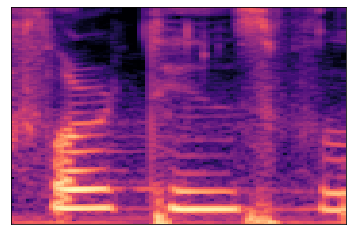

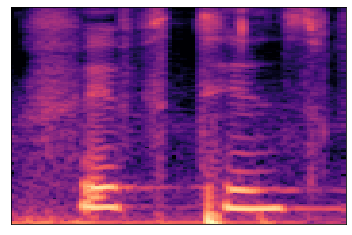

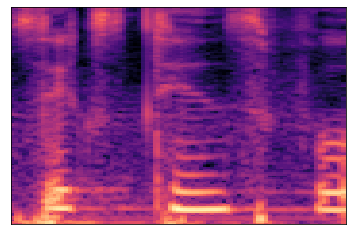

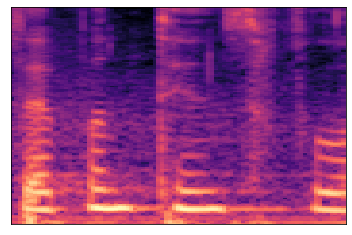

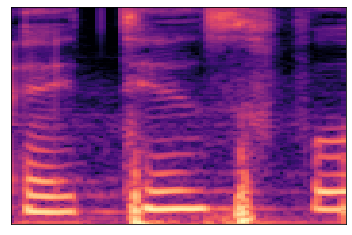

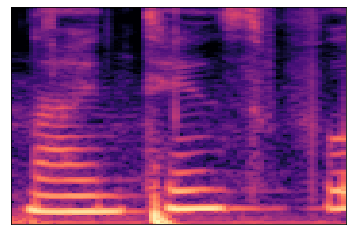

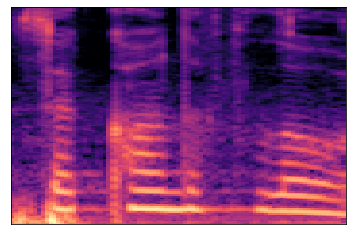

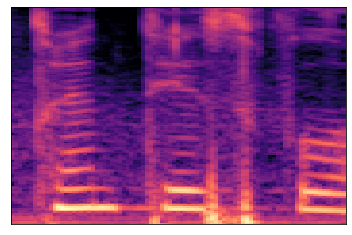

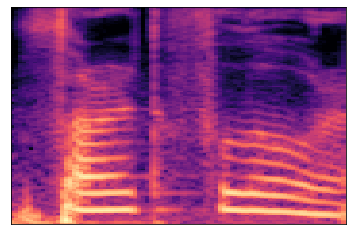

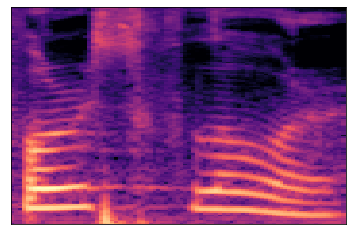

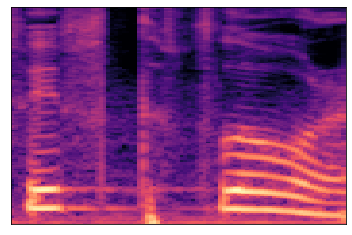

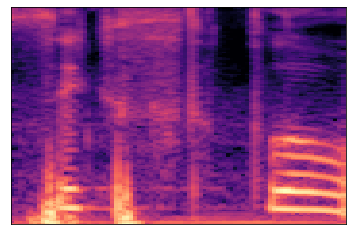

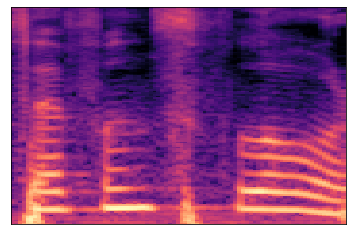

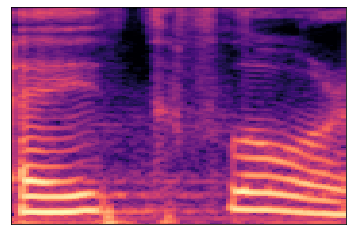

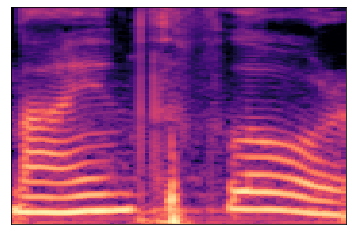

In [70]:
visual_base = '/home/lab/Documents/Human/Elevator_Sound_Classification/Test'
datas = sorted(glob(os.path.join(visual_base, "*", "*")))
visualize = []
for wav in datas:
    if '층' in wav:
        visualize.append(wav)


rows = 10
cols = 2
test_data = Data(visualize)
for i in range(len(visualize)):
    data, label, _ = test_data.__getitem__(i)
    print(label)
    plt.figure()
    
#     fig.add_subplot(rows, cols, i+1)
    librosa.display.specshow(data)


100%|██████████| 3/3 [00:00<00:00, 25.46it/s]

['/home/lab/Documents/Human/Elevator_Sound_Classification/Record/4/Recording (4) WAV - Nagham Meqari_5_x0.5.wav', '/home/lab/Documents/Human/Elevator_Sound_Classification/Record/4/A121A9VXAC6JUQ - Kaveri Selvaratnam_-5.wav', '/home/lab/Documents/Human/Elevator_Sound_Classification/Record/4/fourth-floor1604224535_-2.wav']
4
4
4


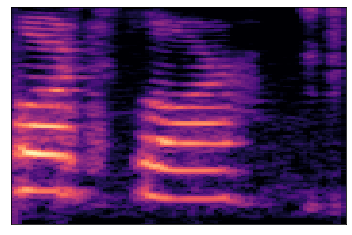

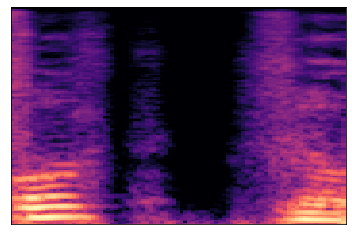

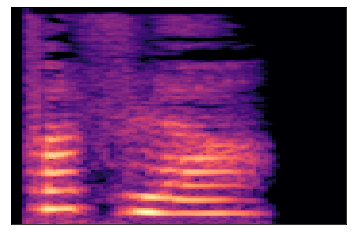

In [132]:
import random
visual_base = '/home/lab/Documents/Human/Elevator_Sound_Classification/Record'
lists  = glob(os.path.join(visual_base, "4", "*"))

datas = [lists[30], lists[88], lists[14]]
print(datas)
visualize = []
for wav in datas:
    if '층' in wav:
        visualize.append(wav)


rows = 10
cols = 2
test_data = Data(datas)
for i in range(len(datas)):
    data, label, _ = test_data.__getitem__(i)
    print(label)
#     print(data.shape)
    plt.figure()
    
#     fig.add_subplot(rows, cols, i+1)
    librosa.display.specshow(data)

100%|██████████| 5/5 [00:00<00:00, 41.10it/s]

16
16
16
16
16


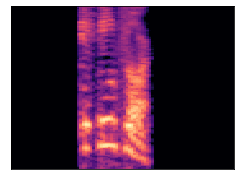

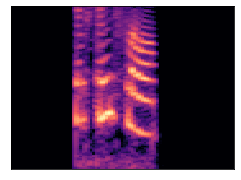

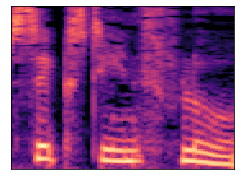

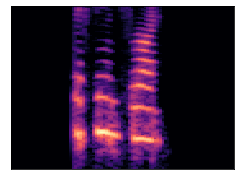

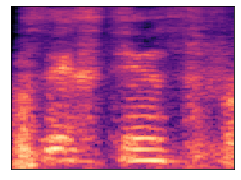

In [109]:
visual_base = '/home/lab/Documents/Human/Elevator_Sound_Classification/Record'
datas = glob(os.path.join(visual_base, "16", "*"))[:5]
visualize = []
for wav in datas:
    if '층' in wav:
        visualize.append(wav)


rows = 10
cols = 2
test_data = Data(datas)
for i in range(len(datas)):
    data, label, _ = test_data.__getitem__(i)
    print(label)
    plt.figure(figsize=(4,3))
    
#     fig.add_subplot(rows, cols, i+1)
    librosa.display.specshow(data)

/home/lab/pytoch1.5/lib/python3.6/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



7
7
7
7
7


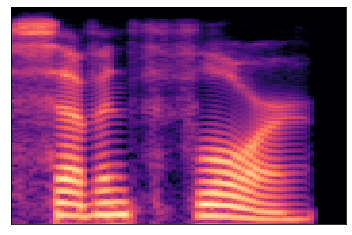

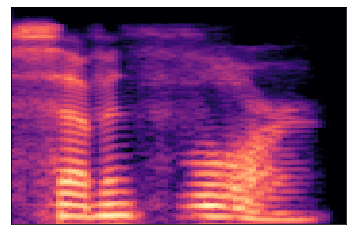

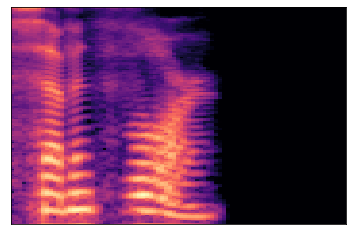

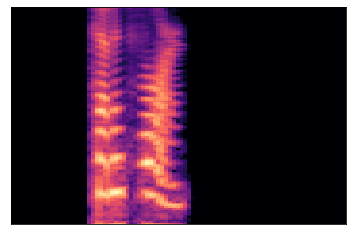

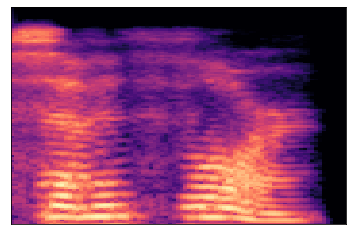

In [86]:
visual_base = '/home/lab/Documents/Human/Elevator_Sound_Classification/Record'
datas = sorted(glob(os.path.join(visual_base, "7", "*")))[:5]
visualize = []
for wav in datas:
    if '층' in wav:
        visualize.append(wav)


rows = 10
cols = 2
test_data = Data(datas)
for i in range(len(datas)):
    data, label, _ = test_data.__getitem__(i)
    print(label)
    plt.figure()
    
#     fig.add_subplot(rows, cols, i+1)
    librosa.display.specshow(data)

/home/lab/pytoch1.5/lib/python3.6/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



10
10
10
10
10


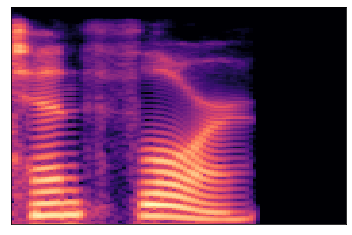

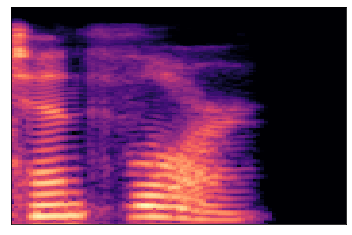

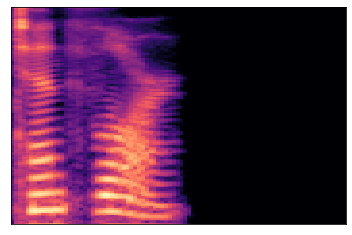

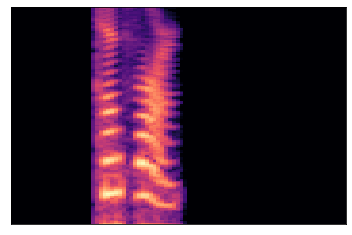

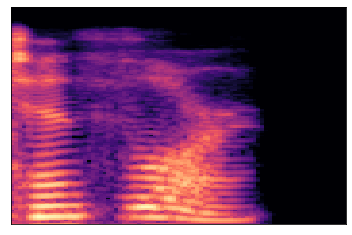

In [87]:
visual_base = '/home/lab/Documents/Human/Elevator_Sound_Classification/Record'
datas = sorted(glob(os.path.join(visual_base, "10", "*")))[:5]
visualize = []
for wav in datas:
    if '층' in wav:
        visualize.append(wav)


rows = 10
cols = 2
test_data = Data(datas)
for i in range(len(datas)):
    data, label, _ = test_data.__getitem__(i)
    print(label)
    plt.figure()
    
#     fig.add_subplot(rows, cols, i+1)
    librosa.display.specshow(data)

In [88]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*- 

import os
import librosa
import soundfile

fail_list = ['Abishini A.H..', 'Craig Emmington','Guilherme Vieira de Araújo', 'TTSmale', 'Anbu Sankar', 'Craig Emmington','TTSfemale', 'Matt D M Burrell' ]

######################################################## pitch ########################################################
for dir_num in range(1, 21):
    path_dir = '/home/lab/Documents/Human/Elevator_Sound_Classification/Test_aug/' + str(dir_num) + '/'
    #path_dir = './thirteenthFloor/'
    file_list = os.listdir(path_dir)
    for file in file_list:
        isFail = False
        
        for fail in fail_list:
            if fail in file:
                isFail = True
                break
        
        if file == '.ipynb_checkpoints':
            continue
            
        if isFail == True:
            continue
        data, sr = librosa.load(path_dir + file)
        
        for i in range(-5, 6):
            output_file_name = file.replace('.wav', '_' + str(i) + '.wav')
            pitch_data = librosa.effects.pitch_shift(data, sr, i)
            soundfile.write(path_dir + output_file_name, pitch_data, sr)


In [89]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*- 

import os
import librosa
import soundfile
import wave
from tqdm import tqdm

fail_list = ['Abishini A.H..', 'Craig Emmington','Guilherme Vieira de Araújo', 'TTSmale', 'Anbu Sankar', 'Craig Emmington','TTSfemale', 'Matt D M Burrell' ]

######################################################## speed ########################################################

CHANNELS = 1
swidth = 2
Change_RATE_1 = 3 #2배속
Change_RATE_2 = 1.5 #0.5배속

for dir_num in range(1, 21):
    path_dir = '/home/lab/Documents/Human/Elevator_Sound_Classification/Test_aug/' + str(dir_num) + '/'
    #path_dir = './thirteenthFloor/'
    file_list = os.listdir(path_dir)
    for file in tqdm(file_list):
        isFail = False
        
        for fail in fail_list:
            if fail in file:
                isFail = True
                break
        
        if file == '.ipynb_checkpoints':
            continue
            
        if isFail == True:
            continue

        # print(path_dir, file)
        try:    
            spf = wave.open(path_dir + file, 'rb')
            
            RATE=spf.getframerate()
            signal = spf.readframes(-1)
            
            output_file_name1 = file.replace('.wav', '_x2.wav')
            wf = wave.open(path_dir + output_file_name1, 'wb')
            wf.setnchannels(CHANNELS)
            wf.setsampwidth(swidth)
            wf.setframerate(RATE*Change_RATE_1)
            wf.writeframes(signal)
            wf.close()
            
            output_file_name2 = file.replace('.wav', '_x0.5.wav')
            wf = wave.open(path_dir + output_file_name2, 'wb')
            wf.setnchannels(CHANNELS)
            wf.setsampwidth(swidth)
            wf.setframerate(RATE*Change_RATE_2)
            wf.writeframes(signal)
            wf.close()
            
        except:
            print(path_dir, file)

100%|██████████| 36/36 [00:00<00:00, 4963.67it/s]


In [93]:
test_aug_path = glob(os.path.join('/home/lab/Documents/Human/Elevator_Sound_Classification/Test_aug', '*', '*'))
test_data = Data(test_aug_path)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

shape = test_data.__getitem__(0)[0].shape
model = Model(input_shape=(1,shape[0],shape[1]), batch_size=16, num_category=20).to(device)

loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)



checkpoint = torch.load(os.path.join(os.path.abspath('.'), 'django_web/parameters','parameters.pth'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


model.eval()
count = 0
result = {}
for i, data in enumerate(test_loader):
    x, y, idx = data
    x_origin = x.clone().cpu().numpy()
    batch, height, width = x.size()
    x = x.view(batch, 1, height, width)
    x = x.to(device, dtype=torch.float32)
    y = y.to(device, dtype=torch.long)
    y_hat = model(x)
    
    

    for b in range(batch):
        pred = (torch.argmax(y_hat[b]) +1).item()
        ground_truth = y[b].item()  
        if ground_truth!= pred:
#             print("ground truth:",ground_truth, 'prediction:',pred )
            item = (ground_truth, pred)
            if (item in result.keys()) is False:
                result[item] = 1
            else:
                result[item] +=1
            count +=1
            
print("error count", count)
result


100%|██████████| 2160/2160 [01:56<00:00, 18.47it/s]


error count 438


{(18, 20): 6,
 (17, 2): 9,
 (3, 9): 20,
 (13, 17): 1,
 (20, 9): 16,
 (16, 15): 38,
 (18, 13): 2,
 (8, 10): 23,
 (1, 4): 24,
 (10, 7): 2,
 (5, 6): 6,
 (14, 13): 36,
 (6, 5): 23,
 (15, 5): 2,
 (2, 15): 12,
 (17, 13): 10,
 (5, 8): 3,
 (7, 2): 26,
 (17, 20): 7,
 (18, 15): 9,
 (12, 1): 21,
 (12, 9): 3,
 (10, 8): 3,
 (15, 16): 11,
 (10, 5): 5,
 (20, 17): 4,
 (9, 4): 5,
 (13, 2): 7,
 (19, 20): 7,
 (7, 10): 6,
 (15, 18): 3,
 (12, 10): 9,
 (15, 14): 1,
 (6, 15): 5,
 (1, 9): 7,
 (13, 3): 1,
 (7, 12): 2,
 (4, 1): 7,
 (7, 17): 6,
 (5, 10): 3,
 (13, 14): 2,
 (9, 10): 2,
 (13, 20): 4,
 (19, 13): 1,
 (10, 12): 1,
 (20, 15): 4,
 (12, 5): 2,
 (20, 13): 4,
 (4, 14): 1,
 (6, 20): 3,
 (14, 17): 3,
 (3, 1): 1,
 (6, 11): 1,
 (7, 20): 1,
 (5, 3): 1,
 (20, 19): 2,
 (9, 19): 1,
 (1, 10): 1,
 (15, 6): 1,
 (18, 2): 1,
 (10, 3): 1,
 (10, 1): 1,
 (20, 12): 1,
 (1, 20): 1,
 (2, 13): 1,
 (6, 10): 1,
 (13, 15): 1,
 (13, 19): 1,
 (6, 8): 1,
 (9, 20): 1}

In [94]:
2160 - 438

1722

In [95]:
1722/2160 * 100

79.72222222222223

In [96]:
visual_base = '/home/lab/Documents/Human/Elevator_Sound_Classification/Record'
a = len(glob(os.path.join(visual_base, '*', '*')))
a

118198

In [98]:
res = sorted(result.items(), key = (lambda x:x[0][0]), reverse = True)
res

[((20, 9), 16),
 ((20, 17), 4),
 ((20, 15), 4),
 ((20, 13), 4),
 ((20, 19), 2),
 ((20, 12), 1),
 ((19, 20), 7),
 ((19, 13), 1),
 ((18, 20), 6),
 ((18, 13), 2),
 ((18, 15), 9),
 ((18, 2), 1),
 ((17, 2), 9),
 ((17, 13), 10),
 ((17, 20), 7),
 ((16, 15), 38),
 ((15, 5), 2),
 ((15, 16), 11),
 ((15, 18), 3),
 ((15, 14), 1),
 ((15, 6), 1),
 ((14, 13), 36),
 ((14, 17), 3),
 ((13, 17), 1),
 ((13, 2), 7),
 ((13, 3), 1),
 ((13, 14), 2),
 ((13, 20), 4),
 ((13, 15), 1),
 ((13, 19), 1),
 ((12, 1), 21),
 ((12, 9), 3),
 ((12, 10), 9),
 ((12, 5), 2),
 ((10, 7), 2),
 ((10, 8), 3),
 ((10, 5), 5),
 ((10, 12), 1),
 ((10, 3), 1),
 ((10, 1), 1),
 ((9, 4), 5),
 ((9, 10), 2),
 ((9, 19), 1),
 ((9, 20), 1),
 ((8, 10), 23),
 ((7, 2), 26),
 ((7, 10), 6),
 ((7, 12), 2),
 ((7, 17), 6),
 ((7, 20), 1),
 ((6, 5), 23),
 ((6, 15), 5),
 ((6, 20), 3),
 ((6, 11), 1),
 ((6, 10), 1),
 ((6, 8), 1),
 ((5, 6), 6),
 ((5, 8), 3),
 ((5, 10), 3),
 ((5, 3), 1),
 ((4, 1), 7),
 ((4, 14), 1),
 ((3, 9), 20),
 ((3, 1), 1),
 ((2, 15), 12),

In [101]:
108 - 39

69

100%|██████████| 5/5 [00:00<00:00, 37.20it/s]


14
14
14
14
14


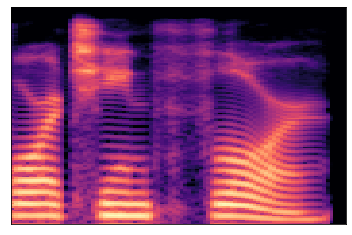

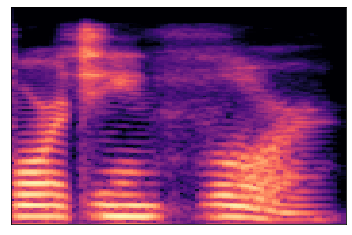

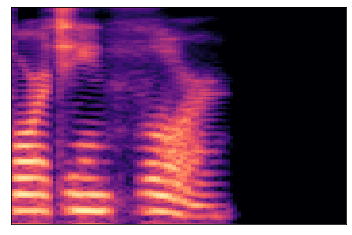

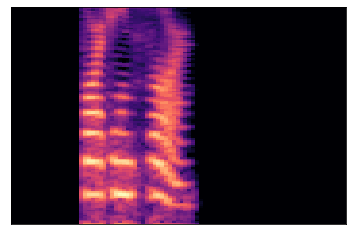

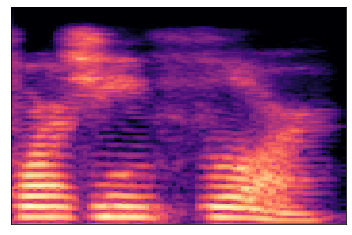

In [105]:
visual_base = '/home/lab/Documents/Human/Elevator_Sound_Classification/Record'
datas = sorted(glob(os.path.join(visual_base, "14", "*")))[:5]
visualize = []
for wav in datas:
    if '층' in wav:
        visualize.append(wav)


rows = 10
cols = 2
test_data = Data(datas)
for i in range(len(datas)):
    data, label, _ = test_data.__getitem__(i)
    print(label)
    plt.figure()
    
#     fig.add_subplot(rows, cols, i+1)
    librosa.display.specshow(data)

100%|██████████| 5/5 [00:00<00:00, 40.96it/s]


13
13
13
13
13


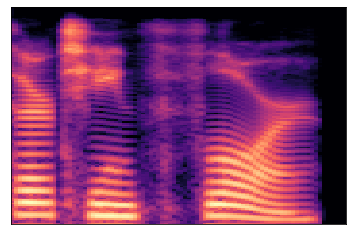

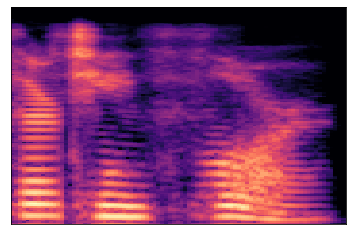

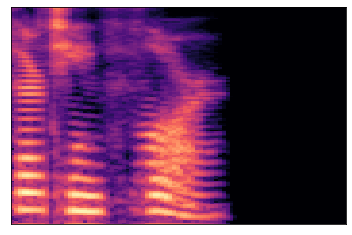

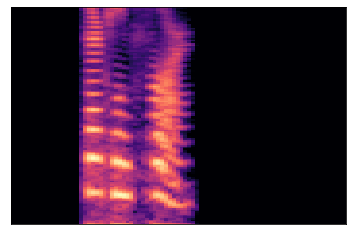

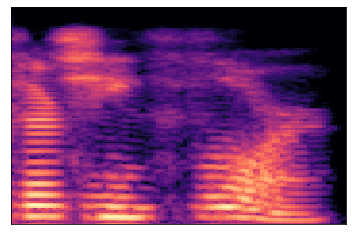

In [106]:
visual_base = '/home/lab/Documents/Human/Elevator_Sound_Classification/Record'
datas = sorted(glob(os.path.join(visual_base, "13", "*")))[:5]
visualize = []
for wav in datas:
    if '층' in wav:
        visualize.append(wav)


rows = 10
cols = 2
test_data = Data(datas)
for i in range(len(datas)):
    data, label, _ = test_data.__getitem__(i)
    print(label)
    plt.figure()
    
#     fig.add_subplot(rows, cols, i+1)
    librosa.display.specshow(data)